<table align="left" style="border-style: hidden" class="table"> <tr><td class="col-md-2"><img style="float" src="http://prob140.org/assets/icon256.png" alt="Prob140 Logo" style="width: 120px;"/></td><td><div align="left"><h3 style="margin-top: 0;">Probability for Data Science</h3><h4 style="margin-top: 20px;">UC Berkeley, Spring 2019</h4><p>Ani Adhikari and Jim Pitman</p>CC BY-NC 4.0</div></td></tr></table><!-- not in pdf -->

In [2]:
from datascience import *
from prob140 import *
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline
import numpy as np
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact
import warnings
warnings.simplefilter('ignore')
from matplotlib.ticker import FormatStrFormatter

In [3]:
def fixed_append(self, row_or_table):
    """Append a row or all rows of a table. An appended table must have all
    columns of self."""
    if not row_or_table:
        return
    if isinstance(row_or_table, Table):
        t = row_or_table
        columns = list(t.select(self.labels)._columns.values())
        n = t.num_rows
    else:
        if (len(list(row_or_table)) != self.num_columns):
            raise Exception('Row should have '+ str(self.num_columns) + " columns")
        columns, n = [[value] for value in row_or_table], 1
    for i, column in enumerate(self._columns):
        # ONLY NEW TWO LINES ADDED
        if isinstance(columns[i][0], np.ndarray): #ADDED THIS LINE
            self._columns[column] = np.array(self._columns[column].tolist() + columns[i] + [np.array([])])[:-1] #ADDED THIS LINE
        else:
            if self.num_rows:
                self._columns[column] = np.append(self[column], columns[i])
            else:
                self._columns[column] = np.array(columns[i])
                
    self._num_rows += n
    return self
Table.append = fixed_append

In [4]:
def override_hist(*args, **kwargs):
    """
    This cleans up some unfortunate floating point precision
    bugs in the datascience library
    """
    #kwargs['edgecolor'] = 'w'
    Table.hist2(*args, **kwargs)
    ax = plt.gca()
    ticks = ax.get_xticks()
    if np.any(np.array(ticks) != np.rint(ticks)):
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if not hasattr(Table, 'hist2'):
    Table.hist2 = Table.hist
    
Table.hist = override_hist

# Lab 10: Chinese Restaurant Process #

In this lab you will analyze a stochastic model for *clustering*, which is a process of visualizing and organizing data based on similarities between sampled individuals. Methods of identifying clusters have applications in a wide variety of areas. Here are just a few examples.

- Criminology: locations where a type of crime occurs
- Marketing: customers who share preferences
- Biology: populations segmented by patterns in genes
- Natural Language Processing: words grouped by similarity of meaning or grammatical properties

One commonly used model is *k-means clustering*, which assumes that the data are continuous numerical variables and that the number of clusters in the population is known to be $k$. By contrast, the *Chinese Restaurant Process* is a discrete time stochastic process that can be used as a model for clustering and does not assume a fixed number of clusters. Instead, the clusters evolve randomly as individuals enter, according to a specified probabilistic structure. The data could be categorical or numerical.

The Chinese Restaurant Process is an example of a *generative Bayesian model* that specifies the probabilistic rules by which the process evolves and in which the representation itself evolves as more data come in.

**History:** The process has its origins in the work of [Warren Ewens](https://en.wikipedia.org/wiki/Warren_Ewens) in the early 1970's, in particular the [Ewens Sampling Formula](https://en.wikipedia.org/wiki/Ewens%27s_sampling_formula) of population genetics. Since then, the development of the theory of the stochastic process and its use in machine learning has been very much a Berkeley enterprise: Jim Pitman, David Aldous, and Mike Jordan are among the people involved. The restaurant analogy is due to Jim Pitman and our late colleague Lester Dubins, during one of their regular cafe meetings decades ago. Though there is a popular story that they came up with it while eating at a Chinese restaurant, in fact they were at the Strada on Bancroft and College; it was called Roma at that time. 

**What you will learn:** In this course we will focus on understanding the probability model. You can then go on to other classes that discuss how to fit the model to data.

You will start by simulating the process and looking at the total number of clusters observed in a fixed amount of time. This theory helps answer questions like these, about $n$ observations:
- How many different animal species do you expect to see?
- What is the distribution of the number of different types of documents that you will have?
- What is the chance that everybody is retweeting the same tweet?

The "restaurant" image is that each person entering the restaurant chooses a table to join. Thus each table becomes a cluster. The model allows for an infinite number of tables, each of infinite size, though of course if you make $n$ observations then the observed number of occupied tables will be finite. That's the number of different clusters observed.

You will then study the long run behavior of the proportion of people at Table 1. This helps answer questions such as:

- About what proportion of the animals are of the same species as the first one you saw?
- What is the chance that more than half the retweets are the same as the first one?

The proportion of people at the first table has some surprising and beautiful properties. You will learn:

- Why the behavior of the proportion supports the idea that "the rich get richer"
- The connection between the long run distribution of the proportion and the beta family

## The Process ##
In keeping with the Chinese Restaurant analogy, think of clusters as groups of people sitting at the same table. We will only consider occupied tables, so the number of tables is equal to the number of clusters. 

The process evolves according to the following rules.
- There is a positive parameter $\theta$.
- People enter the restaurant one at a time.
- Person 1 enters and sits at a table that we will call Table 1.
- Each subsequent person 
    - either joins an existing table with probability proportional to the number of people already at that table, or
    - starts a new table with probability proportional to $\theta$.
- People choose tables independently of each other.

Don't worry about running out of room. The restaurant has infinite capacity and each table is infinitely large. You can imagine infinitely many such tables at the start, or imagine new tables appearing magically each time a person's random choice is to start a new table. We prefer the second image because it consists only of the occupied tables.

Note that the tables are not labeled at the start. We label them according to their order of formation. Thus Table 1 is the table at which Person 1 sits. Table 2 is the next new table to be formed. We can't say exactly who starts it, because that's random. Table 3 is the third new table to be formed. And so on.

To visualize the process, run the cell below. It simulates 100 people arriving according to a Chinese Restaurant process with some value of $\theta$. Move the slider slowly at first, so that you can see the people coming in one at a time. 

Run the cell several times. The value of $\theta$ changes each time and you will see quite a bit of variation in the results. This indicates that you might be able to use this model in varied applications, by setting the parameter appropriately.

In [309]:
visualize_cr()

interactive(children=(IntSlider(value=1, continuous_update=False, description='n', min=1), Output()), _dom_cla…

#newpage

## Part 1: Simulating the Process ##
We will start by specifying a way to describe the state of the process at time $n$. That is when $n$ people have been seated. 

The description is a list such that the $i$th element of the list is the number of people seated at Table $i$ at time $n$. 

In other words, the description is a list of the counts of people at the occupied tables, in order of table formation.

The process starts at time $n = 1$ with one person seated at Table 1. Therefore the state of the process at time 1 is just the list `[1]`.

At each stage, a new person arrives and is seated according to the rules of the process. 

Therefore at time $n = 2$, there are two possible states for the process: either `[2]` if Person 2's random choice was Table 1, or `[1 1]` if Person 2's random choice was to create a new table.

At time $n = 3$ the possible states are `[3]`, `[2 1]`, `[1 2]`, and `[1 1 1]`.

And so on.

### a) One Step Transition ###
Define a function `one_step_cr` that takes two arguments:

- a state of the process
- the parameter $\theta$

The function should simulate the choice made by the next person who enters, and return the state of the process when that person has taken a seat.

Before you start coding, write out what `one_step_cr([2], 1.5)` could evaluate to. There is more than one correct possible value; write all of them.


**Your answer here**

`one_step_cr([2], 1.5)` could evalute to: [3] or [2, 1]

Now define `one_step_cr` using the skeleton code below. You will use `np.random.choice` for the random selection. The call `np.random.choice(values, p = probabilities)` makes one random draw from the distribution that has possible values in the array `values` and the corresponding probabilities in the array `probabilities`.

A note on list indices: The code will convert the chosen value to be of the `int` type, because later you will have to use it as a list index.

A note on lists: If you need to change the element at index `k` of a list `mylist`, say by multiplying the original element by 2, you can use `mylist[k] = mylist[k] * 2`.

In [7]:
np.random.choice(make_array(0,1), p = make_array(0.4, 0.6), size = 50)

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0])

In [294]:

def one_step_cr(counts, theta):
    """Returns the next state of a Chinese Restaurant Process 
    with parameter theta,
    starting with the current state given in the list called counts"""
    
    # Total number of people already seated before the new person arrives
    n = np.sum(counts)
    
    # Labels of all the possible tables the new person could choose
    # Be careful!
    tables = np.arange(1, len(counts)+2)
    
    # The probabilities for all the different tables 
    # the new person could choose, in the order
    # P(Table 1), P(Table 2), ...
    probs = np.append(counts, theta) / (n+theta)
    # The chosen table
    chosen = np.random.choice(tables, p = probs)
    
    # Converted to an int so you can use it as an index:
    chosen = int(chosen)
    
    if chosen > len(counts):
        counts = np.append(counts, 1)
    else:
        counts[chosen - 1] = counts[chosen - 1] + 1 
    
    
    # Return the state of the process once the new person has taken a seat
    return counts

Run the cell below several times and make sure it agrees with your earlier answer.

In [301]:

theta = 100

one_step_cr([2], theta)

array([2, 1])

### b) Steps 1 Through $N$ ###
You can now simulate the first $n$ steps of the process iteratively, starting with the state `[1]` at time $1$. To save you some time recalling `Table.append` and also dealing with the way lists in Python mutate, we have written the code for you. It should be easy for you to read and follow.

Run the cell below. It defines a function `cr` that takes $N$ and $\theta$ as its arguments, simulates the Chinese Restaurant process starting with 1 person at time 1, and returns a table that contains the states of the simulated process at times 1 through $N$.

In [303]:
def cr(N, theta):
    # A table with two columns, but no rows yet
    process = Table(['Time', 'Counts at Tables'])
    
    # initial state
    state = np.array([1])
    # Append a row corresponding to Time 1; this mutates the table
    process.append([1, state])
    
    # Iterate
    for i in np.arange(2, N+1):
        state = one_step_cr(state.copy(), theta) # .copy() deals with list mutation
        process.append([i, state])
    
    return process

Run the cell below several times, changing `N` and `theta` occasionally. Each time, check that the evolution of the states is in accordance with the rules of the process. For example, think about the total number of people that should be seated at each time $n$.

In [316]:

theta = 1
N =10
cr(N, theta)

array([array([1]), array([2]), array([3]), array([4]), array([5]),
       array([6]), array([7]), array([8]), array([9]), array([10])],
      dtype=object)

### c) Visualizing the Clusters ### 

The function `visualize_cr` takes an optional argument that is a state of the process. The function displays the state, that is, the tables and the people seated at them.

Use `visualize_cr` to display a simulated state of the Chinese Restaurant process with parameter 2.5 at time 100.

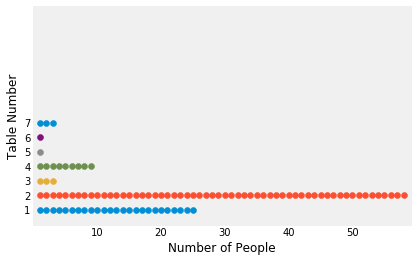

In [343]:

N = 100
theta = 2.5
state = cr(N, theta)[1][N-1]
visualize_cr(state)

### d) Varying $\theta$ ###
Run the cell below with $N = 100$ and $\theta = 0.5$, 1, and 2. Do this several times to get a sense of the variation in the number of tables (clusters) and the distribution of people in them (cluster sizes).

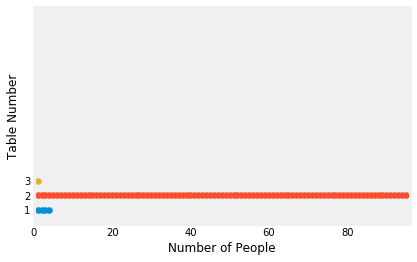

In [382]:

N = 100
theta = 1
state = cr(N, theta)[1][N-1]
visualize_cr(state)

Give a brief qualitative description of what you have seen in the simulations for $N = 100$ and $\theta = 0.5, 1$, and $2$. Address questions such as:

- Are there lots of tables, not many, or is it not possible to tell?
- Is the distribution of the number of people pretty uniform across the tables? If not, describe what you see about the number of big and small clusters.
- In what way does $\theta$ make a difference? Or is it not possible to tell?

As theta increase there tends to be more tables at time N.

The distribution does not look uniform across the table, rather it puts more emphasis on the lower numbered tables. Big clusters tend to be at the bottom, while the small clusters are usually on the top

Increasing theta definitely adds more variation to the number of tables

#newpage

## Part 2. The Rich Get Richer ##

Remember that Person $n$ enters the system at time $n$. Thus time is always equal to the total number of people in the system at that time.

In this part of the lab you will follow the **number** of people at Table 1 as the process evolves.

- At time 1 the number of people at Table 1 is 1 because there is only one person and that person sits at Table 1. 
- At time 2 the number is either 2 (if Person 2 chooses Table 1) or 1 (if Person 2 starts a new table). 
- And so on.

### a) Number at Table 1 ###
Define a function `t1_counts` that takes $N$ and $\theta$ as arguments and does the following:

- Runs the Chinese Restaurant process with parameter $\theta$ till time $N$
- Returns an array of length $N$ such that the $i$th element of the array is the number of people at Table 1 at time $i$

Thus, the first element of the returned array should always be 1. Recall that if the second person joins Table 1, then the second element should be 2. If the third person chooses Table 2, then the third element should still be 2. And so on.

In [383]:

def useful_function(mylist):
    """The argument is a list.
    See the use of the function in the definition of t1_counts below"""
    return mylist[0]

def t1_counts(N, theta):
    return cr(N, theta).apply(useful_function, 1)

Run the cell below several times, varying $N$ and $\theta$ occasionally. Check that the array has the right length and that the elements are consistent with counts evolving over time.

In [423]:
N = 10
theta = 2
t1_counts(N, theta)

array([1, 2, 2, 3, 4, 5, 5, 6, 7, 7])

### b) Plotting the Counts ###
Now define a function `plot_t1_counts` that takes `N`, `theta`, and `repetitions` as its arguments and for each repetition does the following:

- Runs the Chinese Restaurant process with parameter `theta` till time `N` and keeps track of the number of people at Table 1 at each time 1 through $N$.
- Displays a graph of the counts at Table 1 versus time.

We will call each graph a *path* of the number of people at Table 1 as people enter the system.

Don't forget that we start with 1 person.

In [424]:

def plot_t1_counts(N, theta, repetitions):
    n = np.arange(1, N + 1)
    for i in np.arange(repetitions):
        plt.plot(n, t1_counts(N, theta), lw=2)  

Run the following cell several times. Then change $N$ and $\theta$ and run the cell again. Make sure you include $\theta = 0.5$ and $\theta = 2$. If you change the number of paths, keep it fairly small so that you can see the individual paths clearly.

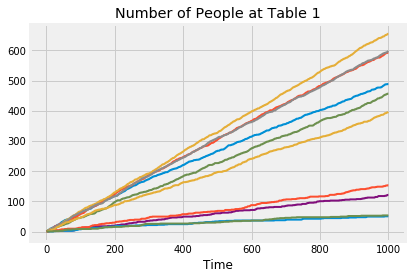

In [432]:
N = 1000
theta = 2
plot_t1_counts(N, theta, 10)
plt.xlabel('Time')
plt.title('Number of People at Table 1');

### c) Interpreting the Plot ###

(i) Each path is the graph of a function of time. What kind of function do you see? Briefly summarize what the paths are likely to look like, based on your observations in **b**.


**Your answer here**

(i) I see a increasing linear function. Each path would differ on the number of N and theta. The function does not look as smooth when theta is large

(ii) Let $W_n$ be the number of people at Table 1 at time $n$, and consider the rate of change of $W_n$ as a function of $n$. Based on your observations in **b**, for paths that have a high rate of change when $n$ is small, is the rate of change typically high or typically low as $n$ gets larger? Explain why it is possible to do a pretty good job of predicting $W_n$ for a large $n$, based on observing the early stages of the process.


**Your answer here**

(ii) If the rate of change is high for small n, the rate of change is continously high as n gets larger. It is evident that as n get larger to graph becomes a smoother linear function which has a constant rate of change. So if you start with a high rate of change, the high rate of change continue. Hence for a large n, it is possible to do a pretty good job of prediction Wn

(iii) The Chinese Restaurant process is said to have the property that "the rich get richer." Briefly explain this in light of your answer to (ii). 

Then explain how you would describe this property to a natural scientist in a context where instead of people there are animals sitting at "tables", where tables are species. It might help to imagine that the data consists of video recorded by a [hidden camera](https://gizmodo.com/how-dslr-camera-traps-are-capturing-stunning-wildlife-p-1730499208) in a nature reserve. 


**Your answer here**

(iii) Based on ii), you basically keep the rate of change that you start with. That is, if you start with high rate of change, you continue to increase at a high rate, whereas if you start with low rate of change, you continue to increase at a lower rate. Hence the rich get richer.

#newpage

## Part 3. Long Run Proportion at Table 1 ##
Now track the **proportion** of people at Table 1, instead of the number of people at the table.

### a) Plotting the Proportions ###
Define a function `plot_t1_proportions` that's just like `plot_t1_counts` except that it plots the proportions of people at Table 1 instead of the counts. Use as many lines as you need.

In [435]:
def plot_t1_proportions(N, theta, repetitions):
    n = np.arange(1, N + 1)
    for i in np.arange(repetitions):
        plt.plot(n, t1_counts(N, theta)/n, lw=2)  

Run the cell below several times, then change $N$ and $\theta$ as in **2b** and run it again several times.

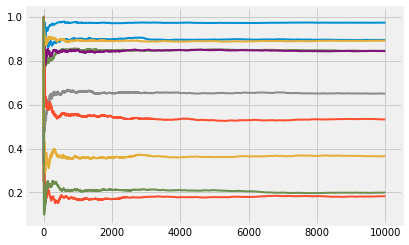

In [440]:
N = 10000
theta = 1
plot_t1_proportions(N, theta, 10)

### b) Convergence ###
What feature of the paths helps us visualize the following result?

If $W_n$ is the number of people at Table 1 at time $n$, then the proportion $\frac{W_n}{n}$ converges with probability 1 as $n \to \infty$.

We see that as N increase, each simulation becomes more of a straight line as we go to the right of the graph. This is similiar behaviour as our weak law of large numbers, and it definitely helps us to visualized that Wn/n converges

#newpage

## Part 4. Limit Distribution of the Proportion ##

Let $W = \lim_{n \to \infty} \frac{W_n}{n}$ be the limit of the proportion of people at Table 1.

Clearly the possible values of $W$ are the interval $(0, 1)$. In this part you will use simulation to identify the distribution of $W$ over the unit interval.

To do this, you will simulate the distribution of $\frac{W_N}{N}$ for a large $N$, and compare it with a known distribution.

### a) Simulating the Proportion ###

Define a function `t1_prop_at_fixed_time` that takes $N$ and $\theta$ as its arguments, simulates the Chinese Restaurant process with parameter $\theta$, and returns the proportion of people at Table 1 at time $N$.

Your function `t1_counts` from Part 2 will be useful.

In [441]:

def t1_prop_at_fixed_time(N, theta):
    return t1_counts(N, theta)[N-1] / N

Now define a function `sim_t1_prop_at_fixed_time` that takes $N$, $\theta$, and a number of repetitions as its arguments. It should return an array of length equal to `repetitions` such that each element of the array is an independently simulated proportion of people at Table 1 at time $N$. Use as many lines as you need.

In [443]:

def sim_t1_prop_at_fixed_time(N, theta, repetitions):
    arr = make_array()
    for i in np.arange(repetitions):
        prop = t1_prop_at_fixed_time(N, theta)
        arr = np.append(arr, prop)
    return arr

Run the cell below to check that the output is an array of proportions and that the array has the correct length.

In [444]:

sim_t1_prop_at_fixed_time(100, 1, 5)

array([0.44, 0.76, 0.82, 0.11, 0.28])

### b) A Beta Distribution ###

Complete the function definition in the cell below. The function should display the empirical histogram of $\frac{W_N}{N}$ with the beta $(1, \theta)$ density overlaid.

In [445]:

# Empirical distribution of W_N/N
# with beta (1, theta) density overlaid

def plot_limit_t1_proportion(N, theta, repetitions):
    t1_props = sim_t1_prop_at_fixed_time(N, theta, repetitions)
    Table().with_column('Proportion at Table 1', t1_props).hist(bins=20)
    x = np.arange(0, 1.01, 0.01)
    plt.plot(x, stats.beta.pdf(x, 1, theta ), color='red', lw=2)
    plt.title('Overlaid Density: Beta'+ r'$(1, \theta)$');

Use `plot_limit_t1_proportion` to display the empirical histogram of $\frac{W_{100}}{100}$ based on 2000 repetitions of the following:

- Run the Chinese Restaurant process with $\theta = 1$ till time 100, and compute $\frac{W_{100}}{100}$

How does the empirical distribution compare with the overlaid beta $(1, \theta)$ density? 

[Note: If you want to experiment with making $N$ larger than 100, be prepared to be patient as the code chugs along.]

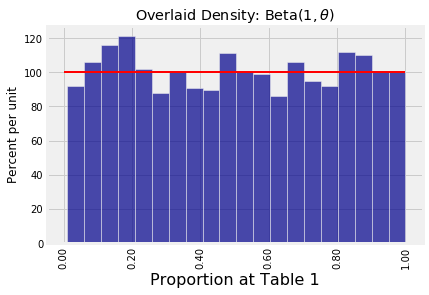

In [446]:
plot_limit_t1_proportion(100, 1, 2000)

### c) Another Beta Distribution ###
Repeat the simulation above keeping everything the same but changing $\theta$ from 1 to 0.5.

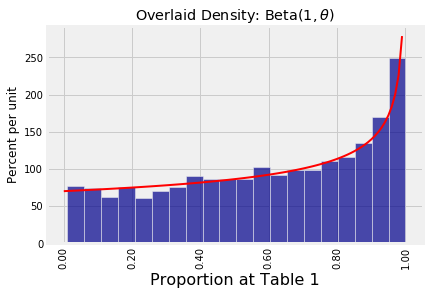

In [447]:

plot_limit_t1_proportion(100, 0.7, 2000)

Give a brief intuitive explanation why the long run proportion of people at Table 1 is more likely to be high than low when $\theta = 0.5$. It will help to think about what happens when the first few people enter the system, and also to keep in mind Part 2 of this lab.


From part 2 of this lab, we observed that the rich gets richer. So if you start with high proportion of table 1 in the beginning you are most likely to have high proportion of table 1 in the end. So with theta = 0.5, this is lower than 1, so there is higher chance of having the new comer sit at table 1. Once the new comer sits at table, the probability to sit at table 1 only increase. So it is more likely to have high proportion of people sitting at table 1 in the beginning. Hence long run proportion of people at Table 1 is most likely to be high. 

### d) ###
Repeat the simulation above keeping everything the same but changing $\theta$ from 0.5 to 2.

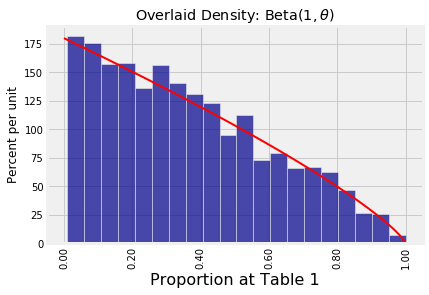

In [449]:

plot_limit_t1_proportion(100, 1.8, 2000)

What you have observed by simulation is an approximation to the distribution of the long run proportion of people at Table 1. 

Why is it beta $(1, \theta)$? Do this week's homework and you'll find out. The Chinese Restaurant process is closely related to the beta-binomial process that you have studied in class.

## Conclusion ##
What you have learned:
- The assumptions of a clustering model in which individuals aren't labeled by type ahead of time and the number of clusters is unknown
- How to simulate data under this model
- The number of people at Table 1 grows in a predictable way after some randomness in the early stages.
- If Table 1 gets rich, then it gets richer.
- The proportion of people at Table 1 has a limit, and the distribution of the limit is a member of the beta family.
- There's got to be a reason why the beta density appears. The cliff-hanger is resolved in this week's homework, via the beta-binomial process.

More advanced analyses of the Chinese Restaurant process include descriptions the joint distribution of the proportions at all the tables. These are related to the *Dirichlet-multinomial* process, which is the multivariate version of the beta-binomial process. 

It's late in the semester and we don't have time to go into all that. But you can skim [a description](https://en.wikipedia.org/wiki/Chinese_restaurant_process) of the Chinese Restaurant process, in which you will spot a lot that is familiar and a lot that isn't. For an illuminating exposition, read the first few pages of [a much-cited paper](http://www.cs.columbia.edu/~blei/papers/BleiGriffithsJordan2009a.pdf) by Blei, Griffiths, and Jordan.  

## Submission Instructions ##

Many assignments throughout the course will have a written portion and a code portion. Please follow the directions below to properly submit both portions.

### Written Portion ###
*  Scan all the pages into a PDF. You can use any scanner or a phone using applications such as CamScanner. Please **DO NOT** simply take pictures using your phone. 
* Please start a new page for each question. If you have already written multiple questions on the same page, you can crop the image in CamScanner or fold your page over (the old-fashioned way). This helps expedite grading.
* It is your responsibility to check that all the work on all the scanned pages is legible.

### Code Portion ###
* **Save your notebook using File > Save and Checkpoint.**
* Run the cell below to generate a PDF file.
* Download the PDF file and confirm that none of your work is missing or cut off.  If the link leads you to a blank page, use [Command]+[S] or [Ctrl]+[S] to download your work. 

### Submitting ###
* Combine the PDFs from the written and code portions into one PDF.  [Here](https://smallpdf.com/merge-pdf) is a useful tool for doing so.  
* Submit the assignment to Lab 10 on Gradescope. 
* **Make sure to assign each page of your pdf to the correct question.**



### **We will not grade assignments which do not have pages selected for each question or were submitted after the deadline.** 

In [ ]:
import gsExport
gsExport.generateSubmission("Lab_10.ipynb")